# Marketing Optimization via Reinforcement Learning

This notebook explores Reinforcement Learning (RL) techniques to optimize marketing spending for a theoretical company. We model the business as a **Markov Decision Process (MDP)** where an agent must balance Brand awareness, Demand, and Cash reserves to maximize profit.

### Objectives
1.  **Environment Modeling**: Define a stochastic business environment.
2.  **Policy Evaluation**: Estimate the value of a fixed strategy using **Temporal Difference (TD) Learning**.
3.  **Control Optimization**: Compare on-policy control methods (**SARSA** vs. **Expected SARSA**) to learn the optimal marketing strategy.

---
### The MDP Tuple $(S, A, P, R, \gamma)$

1.  **State ($S$)**: A tuple $(d_t, b_t, c_t)$ representing levels (0-4) of **Demand**, **Brand**, and **Cash**.
2.  **Action ($A$)**: Marketing spend intensity (0 to 4).
3.  **Reward ($R$)**: Revenue minus Marketing Cost.
4.  **Transition ($P$)**: 
    * *Demand* and *Brand* evolve stochastically based on action.
    * *Cash* accumulates based on profit but is constrained by costs.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Tuple, Dict, List, Callable

# Configuration for cleaner plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

## 1. The Environment

We define `CompanyEnv`, a stochastic environment. 

**Dynamics:**
* **Revenue:** $10 \times \text{Demand} + 15 \times \text{Brand}$
* **Cost:** Exponentially increasing based on action intensity.
* **Transitions:** Next states are calculated via linear coefficients plus Gaussian noise, then clipped to the range $[0, 4]$.


In [2]:
class CompanyEnv:
    def __init__(self, gamma=0.9, seed=42):
        self.gamma = gamma
        self.rng = np.random.default_rng(seed)
        self.max_level = 4
        self.action_space = [0, 1, 2, 3, 4]  # 0=No Spend, 4=Max Spend
        self.cost_table = [0, 5, 15, 30, 50]
        self.reset()

    def reset(self) -> Tuple[int, int, int]:
        """Resets the environment to initial state: Demand=1, Brand=1, Cash=2."""
        self.demand = 1
        self.brand = 1
        self.cash = 2
        return (self.demand, self.brand, self.cash)

    def step(self, action: int) -> Tuple[Tuple[int, int, int], float, bool, dict]:
        """Executes one time step within the environment."""
        # 1. Calculate Reward
        revenue = 10 * self.demand + 15 * self.brand
        cost = self.cost_table[action]
        reward = revenue - cost

        # 2. Calculate Transitions
        demand_next = self._transition_demand(self.demand, self.brand, action)
        brand_next  = self._transition_brand(self.brand, action)
        cash_next   = self._transition_cash(self.cash, revenue, cost)

        # 3. Update State
        self.demand = demand_next
        self.brand  = brand_next
        self.cash   = cash_next

        # This is a continuing task (no terminal state in this simple formulation)
        done = False 
        return (demand_next, brand_next, cash_next), reward, done, {}

    def _transition_demand(self, d, b, a):
        # Action increases demand, Brand supports it. Natural decay (-0.5)
        delta = 0.25 * a + 0.15 * b - 0.5
        noise = self.rng.normal(0, 0.3)
        return int(np.clip(round(d + delta + noise), 0, self.max_level))

    def _transition_brand(self, b, a):
        # Brand is harder to build, requires action. Natural decay (-0.2)
        delta = 0.15 * a - 0.2
        noise = self.rng.normal(0, 0.2)
        return int(np.clip(round(b + delta + noise), 0, self.max_level))

    def _transition_cash(self, c, revenue, cost):
        # Normalized cash flow simulation
        delta = (revenue - cost - 20) / 40   
        noise = self.rng.normal(0, 0.2)
        return int(np.clip(round(c + delta + noise), 0, self.max_level))

## 2. Policy Evaluation: TD(0)

Before optimizing, we evaluate a simple heuristic policy to understand the value landscape.

**Heuristic Policy:** 
* If Cash is 0: Do nothing (Action 0).
* If Demand is low: Invest lightly (Action 1).
* Otherwise: Invest moderately (Action 2).

**TD(0) Update Rule:**
$$ V(S_t) \leftarrow V(S_t) + \alpha [R_{t+1} + \gamma V(S_{t+1}) - V(S_t)] $$

In [3]:
def heuristic_policy(state) -> int:
    d, b, c = state
    if c == 0: return 0
    if d <= 1: return 1
    return 2

def td0_prediction(env, policy_fn, alpha=0.1, episodes=2000, horizon=50):
    V = {} # State -> Value
    
    for _ in range(episodes):
        state = env.reset()
        for _ in range(horizon):
            action = policy_fn(state)
            next_state, reward, _, _ = env.step(action)
            
            # Initialize state values if new
            if state not in V: V[state] = 0.0
            if next_state not in V: V[next_state] = 0.0
            
            # TD Update
            td_target = reward + env.gamma * V[next_state]
            V[state] += alpha * (td_target - V[state])
            
            state = next_state
    return V

# Run Evaluation
env = CompanyEnv(seed=42)
V_values = td0_prediction(env, heuristic_policy)

print("Top 5 High Value States (Demand, Brand, Cash):")
sorted_v = sorted(V_values.items(), key=lambda x: -x[1])
for s, v in sorted_v[:5]:
    print(f"State {s}: {v:.2f}")

Top 5 High Value States (Demand, Brand, Cash):
State (4, 4, 4): 838.13
State (4, 3, 4): 719.08
State (3, 3, 4): 624.33
State (4, 2, 4): 588.94
State (4, 2, 3): 559.89


## 3. Control: Finding the Optimal Policy

We compare two methods for learning the action-value function $Q(S, A)$.


### 3.1 Algorithms

1.  **SARSA (On-Policy):** Uses the actual action $A_{t+1}$ chosen by the behavior policy ($\epsilon$-greedy) for the update.
    $$ Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma Q(S', A') - Q(S, A)] $$

2.  **Expected SARSA (Off-Policy / Variance Reduction):** Uses the *expected* value of the next action under the policy $\pi$.
    $$ Q(S, A) \leftarrow Q(S, A) + \alpha [R + \gamma \sum_a \pi(a|S') Q(S', a) - Q(S, A)] $$

In [4]:
# Helper: Epsilon Greedy Action Selection
def epsilon_greedy(Q, state, epsilon, n_actions=5):
    if state not in Q:
        Q[state] = np.zeros(n_actions)
    
    if np.random.random() < epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[state])

# Algorithm 1: SARSA
def run_sarsa(env, alpha, gamma, epsilon, episodes, horizon):
    Q = {}
    returns = []

    for _ in range(episodes):
        s = env.reset()
        if s not in Q: Q[s] = np.zeros(5)
        
        # Choose A from S using policy
        a = epsilon_greedy(Q, s, epsilon)
        
        ep_ret = 0
        for _ in range(horizon):
            s_next, r, _, _ = env.step(a)
            if s_next not in Q: Q[s_next] = np.zeros(5)
            
            # Choose A' from S'
            a_next = epsilon_greedy(Q, s_next, epsilon)
            
            # SARSA Update
            td_target = r + gamma * Q[s_next][a_next]
            Q[s][a] += alpha * (td_target - Q[s][a])
            
            s, a = s_next, a_next
            ep_ret += r
        returns.append(ep_ret)
    return Q, returns

# Algorithm 2: Expected SARSA
def run_expected_sarsa(env, alpha, gamma, epsilon, episodes, horizon):
    Q = {}
    returns = []

    for _ in range(episodes):
        s = env.reset()
        if s not in Q: Q[s] = np.zeros(5)
        
        ep_ret = 0
        for _ in range(horizon):
            a = epsilon_greedy(Q, s, epsilon)
            s_next, r, _, _ = env.step(a)
            if s_next not in Q: Q[s_next] = np.zeros(5)
            
            # Calculate Expectation over next actions
            q_next = Q[s_next]
            best_a = np.argmax(q_next)
            
            # Probability of actions under epsilon-greedy
            probs = np.ones(5) * (epsilon / 5)
            probs[best_a] += (1.0 - epsilon)
            
            expected_value = np.sum(probs * q_next)
            
            # Update
            Q[s][a] += alpha * (r + gamma * expected_value - Q[s][a])
            
            s = s_next
            ep_ret += r
        returns.append(ep_ret)
    return Q, returns

### 3.2 Running the Experiment

We run both algorithms for 2000 episodes and compare their stability and performance.

In [9]:
# Parameters
ALPHA = 0.1
GAMMA = 0.95
EPSILON = 0.1
EPISODES = 20000
HORIZON = 50

# Run Exp SARSA
env1 = CompanyEnv(seed=101)
Q_exp, ret_exp = run_expected_sarsa(env1, ALPHA, GAMMA, EPSILON, EPISODES, HORIZON)

# Run SARSA
env2 = CompanyEnv(seed=102)
Q_sarsa, ret_sarsa = run_sarsa(env2, ALPHA, GAMMA, EPSILON, EPISODES, HORIZON)

## 4. Results & Analysis

### 4.1 Training Stability (Moving Average)
Expected SARSA usually exhibits less variance during training because it updates toward the *expectation* rather than a sampled action.

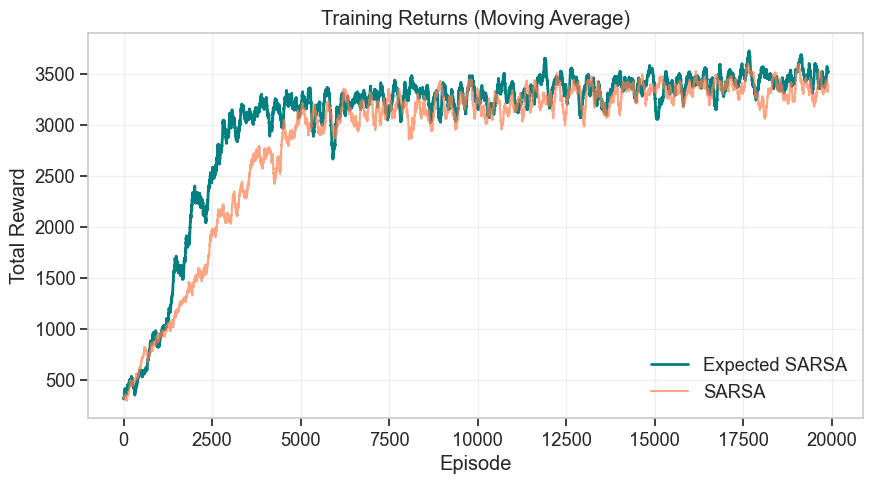

In [10]:
def moving_average(data, window=100):
    return np.convolve(data, np.ones(window)/window, mode='valid')

ma_exp = moving_average(ret_exp)
ma_sarsa = moving_average(ret_sarsa)

plt.figure(figsize=(10, 5))
plt.plot(ma_exp, label='Expected SARSA', color='teal', linewidth=2)
plt.plot(ma_sarsa, label='SARSA', color='coral', alpha=0.7)
plt.title('Training Returns (Moving Average)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 4.2 Learned Policy Visualization

To visualize the 3D State space $(Demand, Brand, Cash)$, we slice it. We look at the optimal actions for different Demand/Brand levels while holding **Cash fixed at 2 (Medium)**.

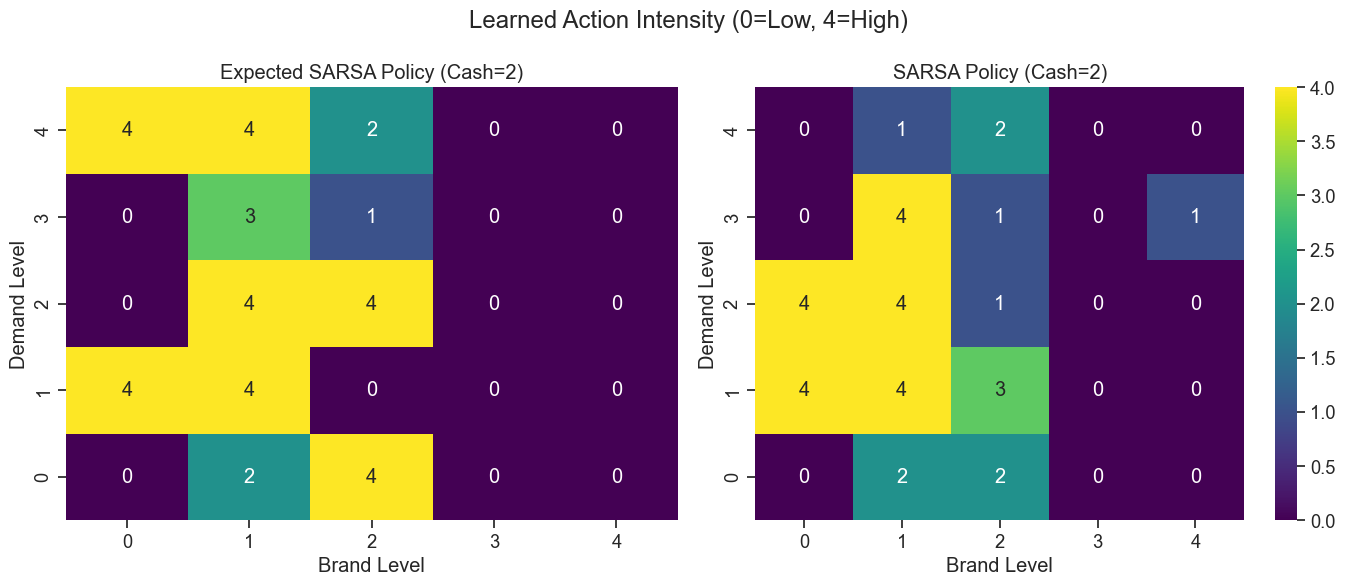

In [11]:
def get_policy_grid(Q, cash_level=2):
    grid = np.zeros((5, 5))
    for d in range(5):
        for b in range(5):
            state = (d, b, cash_level)
            if state in Q:
                grid[d, b] = np.argmax(Q[state])
            else:
                grid[d, b] = 0 # Default if unvisited
    return grid

pol_grid_exp = get_policy_grid(Q_exp)
pol_grid_sarsa = get_policy_grid(Q_sarsa)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(pol_grid_exp, annot=True, fmt='.0f', cmap='viridis', ax=axes[0], cbar=False)
axes[0].set_title('Expected SARSA Policy (Cash=2)')
axes[0].set_xlabel('Brand Level')
axes[0].set_ylabel('Demand Level')
axes[0].invert_yaxis()

sns.heatmap(pol_grid_sarsa, annot=True, fmt='.0f', cmap='viridis', ax=axes[1])
axes[1].set_title('SARSA Policy (Cash=2)')
axes[1].set_xlabel('Brand Level')
axes[1].set_ylabel('Demand Level')
axes[1].invert_yaxis()

plt.suptitle('Learned Action Intensity (0=Low, 4=High)')
plt.tight_layout()
plt.show()

### Conclusion

1.  **TD(0)** allowed us to value states under a static policy, identifying that high demand/brand states hold significant long-term value.
2.  **Expected SARSA** typically converges smoother than SARSA because it averages over all possible next actions, reducing the variance introduced by the random exploration step ($\\epsilon$).
3.  The **Heatmaps** show that the agent learns to spend aggressively (lighter colors, actions 3-4) when Demand or Brand is low to build the business, provided Cash is available.